### TODO

* [x] Load files from the same animal
* [x] Use MatchID to build decoder
* [x] Train on left reward days, test on right
* [x] Compare this to test performance on left
* [ ] Make a plot of results (trained on left, plot results on right)
* [ ] Make a plot of results (trained on LOGO left)

What is our hypothesis again?

That decoder performance for reward prediction decays w reversal while it doesn't for position?
The OFC activity then represents the expectation of reward, not the position, and therefore we can use it to say something about how fast or slow re-learning reward is?


In [1]:
cd /home/blansdel/dnb2_backup_01-26-2025/schwarz/decoder

/home/blansdel/dnb2_backup_01-26-2025/schwarz/decoder


In [2]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [3]:
pwd

'/home/blansdel/dnb2_backup_01-26-2025/schwarz/decoder'

In [4]:
import numpy as np
import pandas as pd
import pickle
from typing import Final

from sklearn.metrics import accuracy_score

from decoder_plotting import *

In [5]:
base_dir = '/home/blansdel/projects/schwarz/decoder/Retracked/'
animals = ['Control Animal 1', 'Control Animal 10', 'Control Animal M3', 'Clonodine Animal F4', 'Clonodine Animal 83', 'IDX Animal F3', 'IDX Animal 80']
sample_dirs = [os.path.join(base_dir, a) for a in animals]

all_files = [
    'retracked_results/results_animal_Control Animal 1.pkl',
    'retracked_results/results_animal_Control Animal 10.pkl',
    'retracked_results/results_animal_Control Animal M3.pkl',
    'retracked_results/results_animal_Clonidine Animal F4.pkl',
    'retracked_results/results_animal_IDX Animal F3.pkl',
    'retracked_results/results_animal_Clonidine Animal 83.pkl',
    'retracked_results/results_animal_IDX Animal 80.pkl'    
]

In [27]:
def compute_cohen(df):
    x = df[df['maze_choice'] == 'left']['accuracy']
    y = df[df['maze_choice'] == 'right']['accuracy']
    return (np.mean(x) - np.mean(y)) / np.sqrt(0.5*(np.std(x)**2 + np.std(y)**2))

def compute_effect_size(test_accuracy_by_group, group_to_maze_choice):
    df_cohen = pd.DataFrame(test_accuracy_by_group.items(), columns=['group', 'accuracy'])
    df_cohen.group = df_cohen.group.str.split('Rds-').str[1]
    df_group_to_maze_choice = pd.DataFrame(group_to_maze_choice.items(), columns=['group', 'maze_choice'])
    df_cohen = df_cohen.merge(df_group_to_maze_choice, on='group')
    effect_size = compute_cohen(df_cohen)
    return effect_size
    
def run_analysis(fn_in):
    with open(fn_in, 'rb') as f:
        results = pickle.load(f)
    test_accuracy_by_group = results['test_accuracy_by_group']
    train_accuracy_by_group = results['train_accuracy_by_group']
    train_accuracy = results['train_accs']
    test_accuracy = results['test_accs']
    test_f1_by_group = results['test_f1_by_group']
    train_f1_by_group = results['train_f1_by_group']

    test_accs_shuffled = results['test_accs_shuffled_all']
    train_accs_shuffled = results['train_accs_shuffled_all']

    test_groups = results['test_groups']
    y_pred_test = results['y_pred_test']
    y_test_kmeans = results['y_test_kmeans']
    maze_choice = results['trial_choice_test']
    y_test_pos = results['y_test_pos']
    test_events = results['test_events']

    #for each group, get the maze choice
    group_to_maze_choice = {}
    for group in test_groups.unique():
        group_to_maze_choice[group.split('Rds-')[1]] = maze_choice[test_groups == group].iloc[0]

    events_and_groups = pd.DataFrame({'event': test_events, 'kmeans': y_test_kmeans})
    events_and_groups.groupby(['kmeans', 'event']).count()

    #Reshape predictions to be by group
    y_pred_test_by_group = []
    y_test_kmeans_by_group = []
    for group in test_groups.unique():
        pred_counts = np.unique(y_pred_test[test_groups == group], return_counts=True)
        #Fill in missing values with zero
        pred_counts = dict(zip(pred_counts[0], pred_counts[1]))
        for i in range(10):
            if i not in pred_counts:
                pred_counts[i] = 0
        #Normalize
        pred_counts = {k: v/sum(pred_counts.values()) for k, v in pred_counts.items()}
        y_pred_test_by_group.append([v[1] for v in sorted(pred_counts.items())])

        #Do the same for the true values
        keamns_counts = np.unique(y_test_kmeans[test_groups == group], return_counts=True)
        keamns_counts = dict(zip(keamns_counts[0], keamns_counts[1]))
        for i in range(10):
            if i not in keamns_counts:
                keamns_counts[i] = 0
        keamns_counts = {k: v/sum(keamns_counts.values()) for k, v in keamns_counts.items()}
        y_test_kmeans_by_group.append([v[1] for v in sorted(keamns_counts.items())])
        effect_size = compute_effect_size(test_accuracy_by_group, group_to_maze_choice)
        
    return effect_size, y_pred_test_by_group, y_test_kmeans_by_group, group_to_maze_choice, test_accuracy_by_group, test_accuracy, train_accuracy, test_f1_by_group, train_f1_by_group, train_accuracy_by_group, test_accs_shuffled, train_accs_shuffled

def run_all_analysis(all_files):
    df = pd.DataFrame()
    for f in all_files:
        effect_size, y_pred_test_by_group, y_test_kmeans_by_group, group_to_maze_choice, test_accuracy_by_group, test_accuracy, train_accuracy, test_f1_by_group, train_f1_by_group, train_accuracy_by_group, test_accs_shuffled, train_accs_shuffled = run_analysis(f)
        row = {
            'animal': f.split('/')[-1].split('.')[0],
            'effect_size': effect_size,
            'maze_choice': group_to_maze_choice,
            'test_accuracy_by_group': test_accuracy_by_group,
            'train_accuracy_by_group': train_accuracy_by_group,
            'test_f1_by_group': test_f1_by_group,
            'train_f1_by_group': train_f1_by_group,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'test_accs_shuffled': test_accs_shuffled,
            'train_accs_shuffled': train_accs_shuffled,
        }
        df = df.append(row, ignore_index=True)
    return df

In [28]:
all_files

['retracked_results/results_animal_Control Animal 1.pkl',
 'retracked_results/results_animal_Control Animal 10.pkl',
 'retracked_results/results_animal_Control Animal M3.pkl',
 'retracked_results/results_animal_Clonidine Animal F4.pkl',
 'retracked_results/results_animal_IDX Animal F3.pkl',
 'retracked_results/results_animal_Clonidine Animal 83.pkl',
 'retracked_results/results_animal_IDX Animal 80.pkl']

In [ ]:
df = run_all_analysis(all_files)
df['test_acc_pvalue'] = df['test_accs_shuffled'].apply(lambda x: np.sum(x > df['test_accuracy'][0]) / len(x))
df['train_acc_pvalue'] = df['train_accs_shuffled'].apply(lambda x: np.sum(x > df['train_accuracy'][0]) / len(x))
df

,animal,effect_size,maze_choice,test_accuracy_by_group,train_accuracy_by_group,test_f1_by_group,train_f1_by_group,train_accuracy,test_accuracy,test_accs_shuffled,train_accs_shuffled,test_acc_pvalue,train_acc_pvalue,test_accs_shuf_max,train_accs_shuf_max
0,results_animal_Control Animal 1,2.512481,"{'7.0-01': 'left', '7.0-02': 'right', '7.0-03'...",{'final_010719.Rds-7.0-01': 0.6273291925465838...,{'final_010713.Rds-2.0-12': 0.3190334533688221...,{'final_010719.Rds-7.0-01': 0.5987405677547216...,{'final_010713.Rds-2.0-12': 0.3347916875493261...,[0.58787],[0.2711513994910941],"[0.1229325699745547, 0.1270674300254453, 0.122...","[0.16476, 0.16489, 0.163885, 0.164905, 0.164, ...",0.0,0.0,0.128287,0.166605
1,results_animal_Control Animal 10,-1.311819,"{'7-01': 'right', '7-02': 'left', '7-03': 'rig...","{'final_100208.Rds-7-01': 0.9097327281896117, ...","{'final_100202.Rds-2-03': 0.4173758163467247, ...","{'final_100208.Rds-7-01': 0.8855568834759872, ...","{'final_100202.Rds-2-03': 0.3744862055559208, ...",[0.64359],[0.3721305595408895],"[0.18172268907563024, 0.18128714900594384, 0.1...","[0.23872, 0.2386, 0.239335, 0.239265, 0.240145...",0.0,0.0,0.185950,0.243050
2,results_animal_Control Animal M3,3.856012,"{'7.0-01': 'left', '7.0-02': 'left', '7.0-03':...",{'final_M30821.Rds-7.0-01': 0.4248878923766816...,{'final_M30815.Rds-2.0-03': 0.8823695213040823...,{'final_M30821.Rds-7.0-01': 0.3298082824842886...,{'final_M30815.Rds-2.0-03': 0.8870282270991977...,[0.69703],[0.20863148479427548],"[0.10370701649771417, 0.1045020870602266, 0.10...","[0.26148, 0.26116, 0.2592, 0.260235, 0.262, 0....",0.0,0.0,0.108751,0.263570
3,results_animal_Clonidine Animal F4,5.006119,"{'7.0-01': 'left', '7.0-02': 'left', '7.0-03':...",{'final_F40821.Rds-7.0-01': 0.7467811158798283...,{'final_F40815.Rds-2.0-04': 0.4708628739408611...,{'final_F40821.Rds-7.0-01': 0.7138146241406604...,{'final_F40815.Rds-2.0-04': 0.4825922836741796...,[0.683955],[0.3478574619428886],"[0.19233016047558504, 0.19148253782802424, 0.1...","[0.26631, 0.265485, 0.26394, 0.26331, 0.264725...",0.0,0.0,0.194518,0.267565
4,results_animal_IDX Animal F3,1.954130,"{'7.0-01': 'left', '7.0-02': 'left', '7.0-03':...",{'final_F30821.Rds-7.0-01': 0.2416267942583732...,{'final_F30820.Rds-6.0-12': 0.6175218636328458...,{'final_F30821.Rds-7.0-01': 0.1274086535962645...,{'final_F30820.Rds-6.0-12': 0.5919906299041339...,[0.67461],[0.2933573645353432],"[0.2025560460319602, 0.20465716984405422, 0.20...","[0.272345, 0.27114, 0.27289, 0.273735, 0.27411...",0.0,0.0,0.207221,0.274870
5,results_animal_Clonidine Animal 83,3.018375,"{'7.0-1.0': 'left', '7.0-10.0': 'left', '7.0-1...",{'final_830719.Rds-7.0-1.0': 0.632352941176470...,{'final_830713.Rds-2.0-7.0': 0.659434620753839...,{'final_830719.Rds-7.0-1.0': 0.572907143270780...,{'final_830713.Rds-2.0-7.0': 0.656586299590650...,[0.59855],[0.23180887689587792],"[0.12654694333302316, 0.12643063180422442, 0.1...","[0.16383, 0.163695, 0.16301, 0.164395, 0.16273...",0.0,0.0,0.131409,0.165965
6,results_animal_IDX Animal 80,-1.446463,"{'7.0-01': 'left', '7.0-02': 'right', '7.0-03'...",{'final_801003.Rds-7.0-01': 0.2622187742435997...,{'final_801002.Rds-6.0-04': 0.7295242766061795...,{'final_801003.Rds-7.0-01': 0.2967608238151722...,{'final_801002.Rds-6.0-04': 0.7066696279071228...,[0.5997],[0.2810009065049545],"[0.11220343221531055, 0.11320371354443437, 0.1...","[0.231745, 0.231885, 0.232825, 0.23335, 0.2302...",0.0,0.0,0.115454,0.234840


### Accuracy plot

Make plot for decoder accuracy and F1 scores

In [23]:
df_plot = df.copy()
df_plot['train_accuracy_by_group'] = df['train_accuracy_by_group'].apply(lambda x: [v[1] for v in sorted(x.items())])
df_plot['test_accuracy_by_group'] = df['test_accuracy_by_group'].apply(lambda x: [v[1] for v in sorted(x.items())])

df_plot_test = df_plot.explode('test_accuracy_by_group')
df_plot_test = df_plot_test.rename(columns={'test_accuracy_by_group': 'accuracy_by_group'})
df_plot_test['condition'] = 'rev'
df_plot_train = df_plot.explode('train_accuracy_by_group')
df_plot_train = df_plot_train.rename(columns={'train_accuracy_by_group': 'accuracy_by_group'})
df_plot_train['condition'] = 'train'

#Concat the two
df_plot = pd.concat([df_plot_test, df_plot_train], ignore_index=True)

df_plot['treatment'] = df_plot['animal'].str.split('_').str[-1].str.split(' ').str[0]
df_plot = df_plot[['animal', 'treatment', 'condition', 'accuracy_by_group']]

<Figure size 720x432 with 0 Axes>

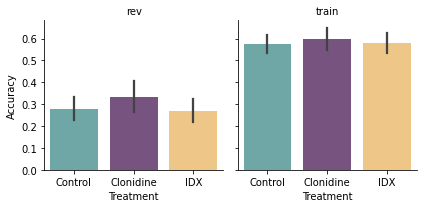

In [24]:
#Use seaborn to make a set of box plots, one for each animal
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
g = sns.FacetGrid(df_plot, col = 'condition', hue = 'treatment')

colors = {
    'Control': '#64b1af',
    'Clonidine': '#7c4d87',
    'IDX': '#ffcb77'
}
g.map_dataframe(sns.barplot, x='treatment', y='accuracy_by_group', hue = 'treatment', palette=colors)
g.set_titles(col_template = '{col_name}')

#Change y axis label
g.set_axis_labels('Treatment', 'Accuracy')

plt.savefig('train_test_accuracy_position_decoder.png', dpi=300)

### F1 Plot

In [25]:
df_plot = df.copy()
df_plot['train_f1_by_group'] = df['train_f1_by_group'].apply(lambda x: [v[1] for v in sorted(x.items())])
df_plot['test_f1_by_group'] = df['test_f1_by_group'].apply(lambda x: [v[1] for v in sorted(x.items())])

df_plot_test = df_plot.explode('test_f1_by_group')
df_plot_test = df_plot_test.rename(columns={'test_f1_by_group': 'f1_by_group'})
df_plot_test['condition'] = 'rev'
df_plot_train = df_plot.explode('train_f1_by_group')
df_plot_train = df_plot_train.rename(columns={'train_f1_by_group': 'f1_by_group'})
df_plot_train['condition'] = 'train'

#Concat the two
df_plot = pd.concat([df_plot_test, df_plot_train], ignore_index=True)

df_plot['treatment'] = df_plot['animal'].str.split('_').str[-1].str.split(' ').str[0]
df_plot = df_plot[['animal', 'treatment', 'condition', 'f1_by_group']]

<Figure size 720x432 with 0 Axes>

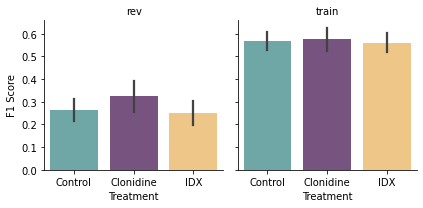

In [26]:
#Use seaborn to make a set of box plots, one for each animal
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
g = sns.FacetGrid(df_plot, col = 'condition', hue = 'treatment')

colors = {
    'Control': '#64b1af',
    'Clonidine': '#7c4d87',
    'IDX': '#ffcb77'
}
g.map_dataframe(sns.barplot, x='treatment', y='f1_by_group', hue = 'treatment', palette=colors)
g.set_titles(col_template = '{col_name}')

#Change axis labels
g.set_axis_labels('Treatment', 'F1 Score')

plt.savefig('train_test_f1_position_decoder.png', dpi=300)

## Shuffling

### Effect size

How can we quantify this? We have variance in accuracy for previously-rewarded maze choice, and variance in accuracy 

In [25]:
df['abs_effect_size'] = df['effect_size'].abs()
df['animal_name'] = df['animal'].str.split('Animal ').str[0].str.split('_').str[-1]
df

,animal,effect_size,maze_choice,test_accuracy_by_group,abs_effect_size,animal_name
0,results_animal_Control Animal 1,2.451364,"{'7.0-01': 'left', '7.0-02': 'right', '7.0-03'...",{'final_010719.Rds-7.0-01': 0.6161490683229813...,2.451364,Control
1,results_animal_Control Animal 10,-1.208335,"{'7-01': 'right', '7-02': 'left', '7-03': 'rig...","{'final_100208.Rds-7-01': 0.9097327281896117, ...",1.208335,Control
2,results_animal_Control Animal M3,3.101756,"{'7.0-01': 'left', '7.0-02': 'left', '7.0-03':...",{'final_M30821.Rds-7.0-01': 0.6894618834080718...,3.101756,Control
3,results_animal_Clonidine Animal F4,5.091168,"{'7.0-01': 'left', '7.0-02': 'left', '7.0-03':...",{'final_F40821.Rds-7.0-01': 0.7461679950950337...,5.091168,Clonidine
4,results_animal_IDX Animal F3,1.894003,"{'7.0-01': 'left', '7.0-02': 'left', '7.0-03':...",{'final_F30821.Rds-7.0-01': 0.2440191387559808...,1.894003,IDX
5,results_animal_Clonidine Animal 83,3.033472,"{'7.0-1.0': 'left', '7.0-10.0': 'left', '7.0-1...",{'final_830719.Rds-7.0-1.0': 0.631787330316742...,3.033472,Clonidine
6,results_animal_IDX Animal 80,-1.207220,"{'7.0-01': 'left', '7.0-02': 'right', '7.0-03'...",{'final_801003.Rds-7.0-01': 0.4553917765709853...,1.207220,IDX


In [26]:
#Compute mean of abs_effect_size by animal_name
df_mean = df.groupby('animal_name').mean().reset_index()

In [27]:
df_mean

,animal_name,effect_size,abs_effect_size
0,Clonidine,4.062320,4.062320
1,Control,1.448262,2.253818
2,IDX,0.343392,1.550611


In [42]:
# Run an anova test on the abs_effect_size by animal_name
from scipy import stats

group_a = df[df.animal_name == 'Clonidine ']['abs_effect_size']
group_b = df[df.animal_name == 'Control ']['abs_effect_size']
group_c = df[df.animal_name == 'IDX ']['abs_effect_size']

f_stat, p_value = stats.kruskal(group_a, group_b, group_c)

In [43]:
p_value

0.18009231214795254